# Challenge Goal:

**Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .**

In [1]:
# Importing necessary libraries for data handling, manipulation, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


In [2]:
users_df = pd.read_csv('takehome_users.csv' , encoding= 'Latin-1')                  #loading dataset using latin-1 encoding
engagement_df = pd.read_csv('takehome_user_engagement.csv' , encoding= 'Latin-1')

# Step 2: Understand and Explore the Data

In [3]:
print(users_df.info())      # observing the structure and any missing values
print(engagement_df.info()) # observing engagement data structure and missing values


users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Co

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Step 3: Define “Adopted User” (3+ logins within 7 days)

In [5]:
# Converting time_stamp to datetime for easier date manipulations
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Sorting by user_id and date to make the rolling window calculation easier
engagement_df = engagement_df.sort_values(['user_id', 'time_stamp'])

# Grouping by each user and check if any 7-day period has 3 or more logins
# I'll use a rolling window to count logins in any given 7-day span

adopted_users = []
for user_id, group in engagement_df.groupby('user_id'):
    group = group.set_index('time_stamp')
    # Rolling window of 7 days with min_periods=3 means we need at least 3 entries in that window
    rolling_counts = group.rolling('7D').count()['user_id']
    if any(rolling_counts >= 3):  # Check if any window has 3 or more logins
        adopted_users.append(user_id)

        
# Creating an 'adopted_user' column in the users_df indicating whether the user is in the adopted list
users_df['adopted_user'] = users_df['object_id'].isin(adopted_users).astype(int)


# Step 4: Feature Engineering

In [6]:
# One-hot encode the creation source (categorical feature) or dummy numerical fetures for categorical columns
users_df = pd.get_dummies(users_df, columns=['creation_source'], drop_first=True)

# Calculating the time since creation to last session in days
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

# Creating a feature 'days_active' representing the time between creation and last session
users_df['days_active'] = (users_df['last_session_creation_time'] - users_df['creation_time']).dt.days

# Droping  unneeded columns for the analysis
users_df = users_df.drop(['name', 'email', 'org_id', 'invited_by_user_id'], axis=1)


# Step 5: Data Analysis and Visualization

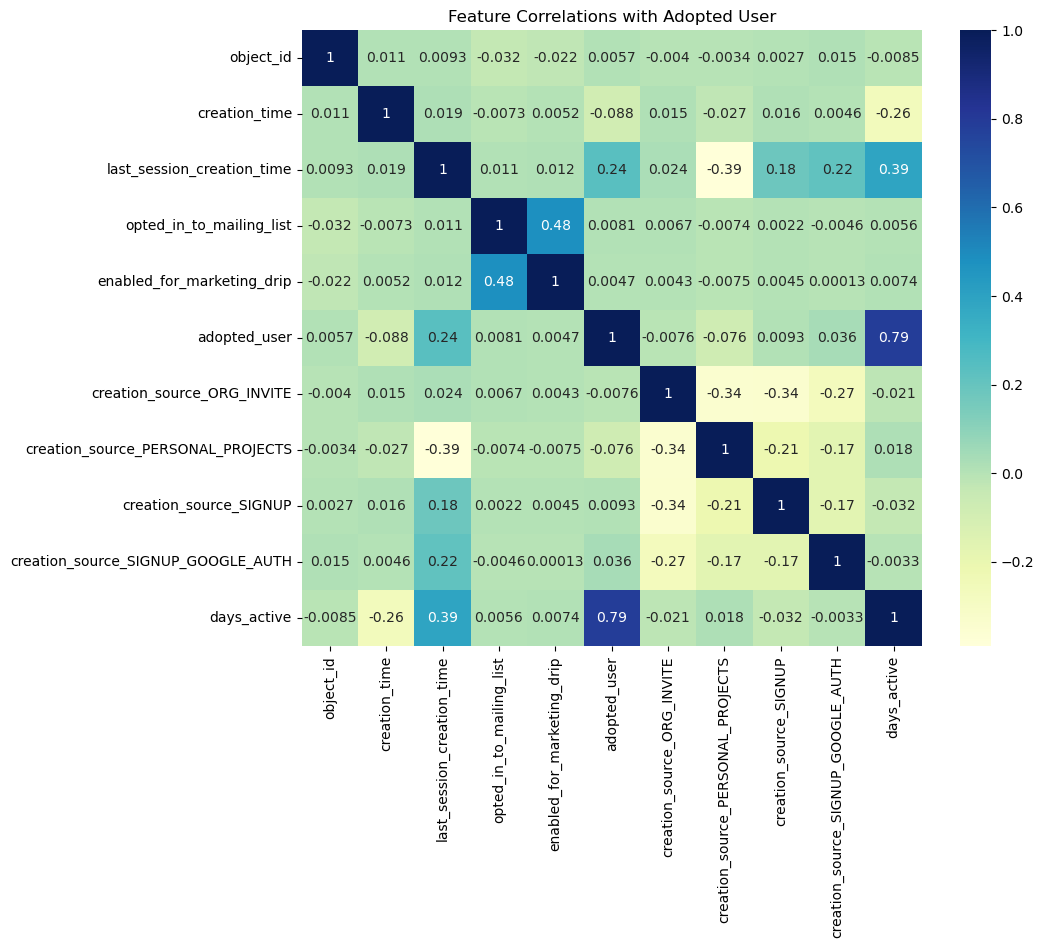

In [7]:
# Correlation heatmap to see feature relationships with adopted_user

plt.figure(figsize=(10, 8))
sns.heatmap(users_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Feature Correlations with Adopted User")
plt.show()


In [8]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   object_id                           12000 non-null  int64         
 1   creation_time                       12000 non-null  datetime64[ns]
 2   last_session_creation_time          8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list            12000 non-null  int64         
 4   enabled_for_marketing_drip          12000 non-null  int64         
 5   adopted_user                        12000 non-null  int32         
 6   creation_source_ORG_INVITE          12000 non-null  bool          
 7   creation_source_PERSONAL_PROJECTS   12000 non-null  bool          
 8   creation_source_SIGNUP              12000 non-null  bool          
 9   creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  bool          
 10  days_active           

# Step 6: Train-Test Split and Modeling

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [10]:
# Converting 'creation_time' and 'last_session_creation_time' to datetime if they are not already
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'], errors='coerce')
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s', errors='coerce')



# Setting a reference date as the earliest creation date in the dataset
reference_date = users_df['creation_time'].min()

# Creating numeric features for the number of days since the reference date
users_df['creation_days'] = (users_df['creation_time'] - reference_date).dt.days
users_df['last_session_days'] = (users_df['last_session_creation_time'] - reference_date).dt.days

# Drop original datetime columns to avoid any issues with non-numeric data
users_df = users_df.drop(['creation_time', 'last_session_creation_time'], axis=1)

# Filling NaN values in newly created columns with appropriate values
users_df['creation_days'].fillna(users_df['creation_days'].mean(), inplace=True)
users_df['last_session_days'].fillna(users_df['last_session_days'].max() + 1, inplace=True)

# Ensure any remaining NaN values in other columns are handled
users_df = users_df.fillna(0)


# Define features (X) and target (y)
X = users_df.drop('adopted_user', axis=1)
y = users_df['adopted_user']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initializing and training the model
model = RandomForestClassifier(random_state=14)
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9761111111111112
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3114
           1       0.93      0.90      0.91       486

    accuracy                           0.98      3600
   macro avg       0.95      0.94      0.95      3600
weighted avg       0.98      0.98      0.98      3600



# Step 7: Interpret Results

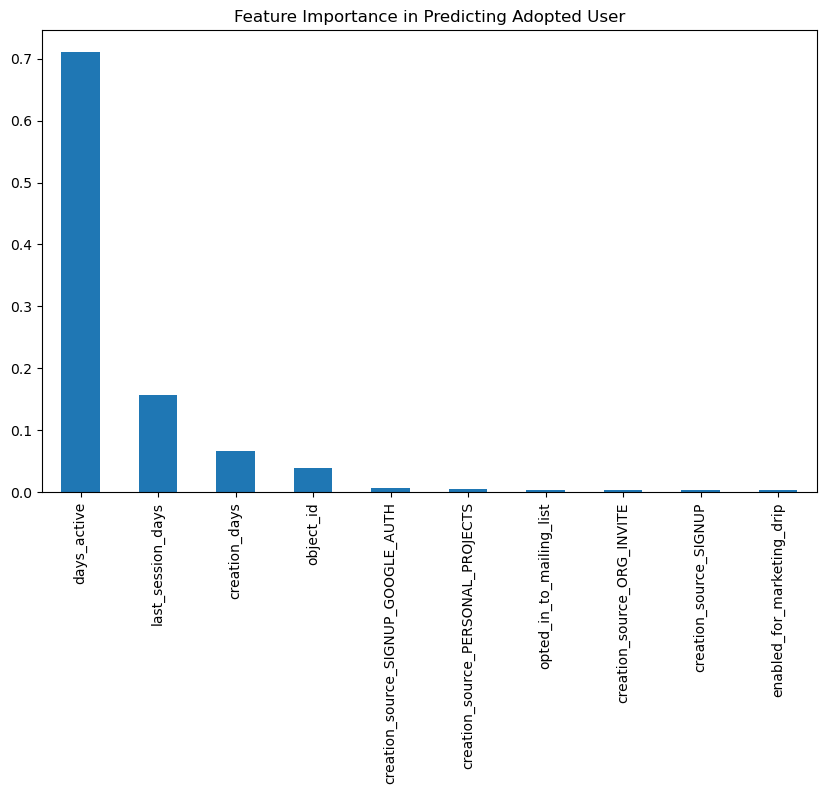

In [11]:
# now visualizing Feature importance to see which factors are most influential for user adoption

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importance in Predicting Adopted User")
plt.show()


# Step 8: Final Summary and Next Steps

#### 1. **Objective Recap**:
   My goal was to identify factors that predict whether a user becomes an "adopted user," defined as someone who logs in on three separate days within at least one seven-day period.


#### 2 **Exploratory Analysis Findings**:

   - **Correlation Analysis**: Certain features shows weak to moderate correlations with the "adopted user" status. However, `days_active` showed the strongest positive correlation, indicating that the longer a user stays active, the more likely they are to be an adopted user.
   
   - **Feature Importance** (from the Random Forest model): 
     
     - **Top Features**: `days_active` and `last_session_days` stood out as the most influential predictors of user adoption. This makes sense, as users who engage with the platform consistently over time are more likely to become adopted.
    
    - **Other Factors**: Variables like `creation_source` (e.g., sign-up source) and `opted_in_to_mailing_list` had relatively low importance, suggesting that account setup details and marketing preferences had limited influence on whether a user became adopted.


#### 3. **Model Performance**:

   - **Accuracy**: The Random Forest model achieved an accuracy of approximately 97.6%, with high precision and recall, especially for non-adopted users.
   
   - **Precision and Recall**: The model demonstrated strong performance in identifying both adopted and non-adopted users, with an F1-score of around 0.91 for adopted users and 0.99 for non-adopted users. This indicates that the model is reliable in predicting user adoption status based on the selected features.


# Conclusion:

   - **Key Predictors**:
     - **Engagement Duration**: `days_active` and `last_session_days` were the primary indicators. Users who maintained active engagement over time were more likely to become adopted.
     
     - **Account Age and Recency**: `creation_days` also played a role but was less influential than `days_active`. Users with recent accounts but consistent activity had a higher chance of being adopted.
     
   - **Less Influential Factors**:
     - **Creation Source** and **Marketing Preferences** (like opting into the mailing list) had minimal impact. This suggests that initial sign-up methods or marketing engagement alone are not strong predictors of long-term product adoption.
